<a href="https://colab.research.google.com/github/Cado87/Fruit-classification/blob/main/Fruit_classifier_dataset_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download dataset

In [ ]:
import requests

url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5prc54r4rt-1.zip"
headers = {}  # Define headers as an empty dictionary
response = requests.get(url, headers=headers)

# Save the downloaded content to a file
with open("dataset.zip", "wb") as f:
    f.write(response.content)

Unzip file

In [ ]:
import zipfile
import os

# Specify the path to the downloaded zip file
zip_file_path = "dataset.zip"

# Specify the directory where you want to extract the contents
extract_dir = "extracted_dataset"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File '{zip_file_path}' unzipped to '{extract_dir}'")

File 'dataset.zip' unzipped to 'extracted_dataset'


Analize labels

In [ ]:
import pandas as pd
import os

labels_train_path = "/content/extracted_dataset/DeepFruits Dataset of Fruits Images with different combinations for Fruit Recognition and Calories Estimation/Labels_Train.csv"
labels_test_path = "/content/extracted_dataset/DeepFruits Dataset of Fruits Images with different combinations for Fruit Recognition and Calories Estimation/Labels_Test.csv"

# Load the CSV files
labels_train_df = pd.read_csv(labels_train_path)
labels_test_df = pd.read_csv(labels_test_path)

# Find duplicated filenames in each dataframe
train_duplicates = labels_train_df[labels_train_df['FileName'].duplicated(keep=False)]
test_duplicates = labels_test_df[labels_test_df['FileName'].duplicated(keep=False)]

# Get the list of duplicated filenames from both dataframes
duplicated_filenames = pd.concat([train_duplicates['FileName'], test_duplicates['FileName']]).unique()

# Remove rows with duplicated filenames from the original dataframes
labels_train_df_filtered = labels_train_df[~labels_train_df['FileName'].isin(duplicated_filenames)]
labels_test_df_filtered = labels_test_df[~labels_test_df['FileName'].isin(duplicated_filenames)]

# Combine the filtered dataframes
all_labels_df = pd.concat([labels_train_df_filtered, labels_test_df_filtered])

# Get the list of fruit columns (excluding 'FileName')
fruit_columns = all_labels_df.columns.tolist()
fruit_columns.remove('FileName')

# Calculate the sum of '1's for each fruit column
label_counts = all_labels_df[fruit_columns].sum()

print("Label counts in the dataset after removing duplicated filenames:")
display(label_counts)

print(f"\nTotal number of classes: {len(fruit_columns)}")
print(f"\nNumber of unique filenames after removing duplicates: {len(all_labels_df)}")
print(f"\nNumber of filenames removed due to duplication: {len(duplicated_filenames)}")

Label counts in the dataset after removing duplicated filenames:


,0
Mango,2761
Grape,2803
Plum,3271
Kiwi,3271
Pear,3811
Apple,3837
Orange,3369
Banana,3369
Pomegranate,3369
Strawberry,3837



Total number of classes: 20

Number of unique filenames after removing duplicates: 15246

Number of filenames removed due to duplication: 2158


In [ ]:
# Count duplicated filenames in the 'FileName' column
duplicated_filenames_count = all_labels_df['FileName'].duplicated().sum()

print(f"Number of duplicated filenames: {duplicated_filenames_count}")

Number of duplicated filenames: 400


Check folders and images inside

In [ ]:
import os

dataset_path = "/content/extracted_dataset/DeepFruits Dataset of Fruits Images with different combinations for Fruit Recognition and Calories Estimation"
folders_to_check = [
    os.path.join(dataset_path, "Fruits_Dataset_Train"),
    os.path.join(dataset_path, "Fruits_Dataset_Test")
]

image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
total_image_count = 0

for folder_path in folders_to_check:
    if os.path.isdir(folder_path):
        print(f"Checking folder: {folder_path}")
        for subfolder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder_name)
            if os.path.isdir(subfolder_path):
                image_count = 0
                for file_name in os.listdir(subfolder_path):
                    if any(file_name.lower().endswith(ext) for ext in image_extensions):
                        image_count += 1
                print(f"  Folder '{subfolder_name}': {image_count} images")
                total_image_count += image_count

print(f"\nTotal number of images in all checked subfolders: {total_image_count}")


Checking folder: /content/extracted_dataset/DeepFruits Dataset of Fruits Images with different combinations for Fruit Recognition and Calories Estimation/Fruits_Dataset_Train
  Folder '7': 408 images
  Folder '2': 3808 images
  Folder '4': 3264 images
  Folder '1': 3486 images
  Folder '8': 840 images
  Folder '3': 3866 images
  Folder '6': 840 images
  Folder '5': 387 images
Checking folder: /content/extracted_dataset/DeepFruits Dataset of Fruits Images with different combinations for Fruit Recognition and Calories Estimation/Fruits_Dataset_Test
  Folder '7': 102 images
  Folder '2': 952 images
  Folder '4': 816 images
  Folder '1': 871 images
  Folder '8': 210 images
  Folder '3': 966 images
  Folder '6': 210 images
  Folder '5': 96 images

Total number of images in all checked subfolders: 21122


Visualize random images

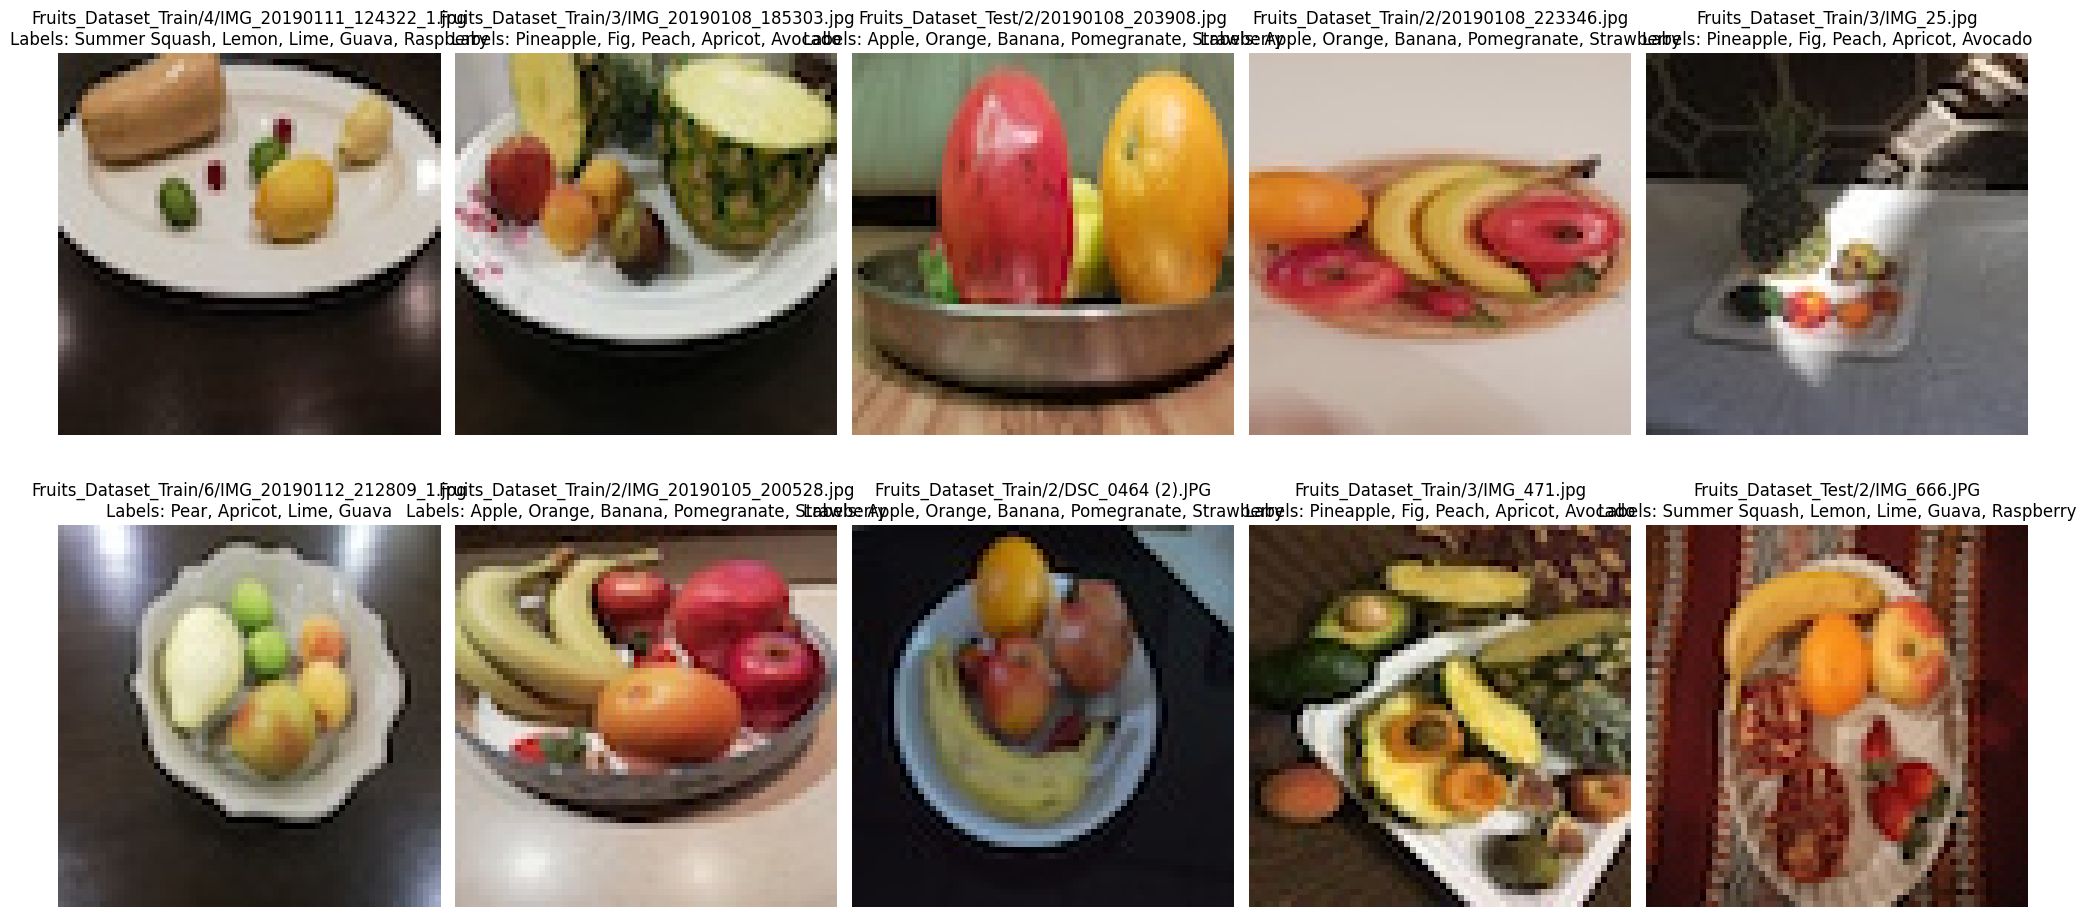

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
import pandas as pd

all_image_files = []
# Create a set of filenames from all_labels_df for efficient lookup
labeled_filenames = set(all_labels_df['FileName'])

for folder_path in folders_to_check:
    if os.path.isdir(folder_path):
        for subfolder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder_name)
            if os.path.isdir(subfolder_path):
                for file_name in os.listdir(subfolder_path):
                    # Check if the file has a valid image extension and is in the labeled_filenames set
                    if any(file_name.lower().endswith(ext) for ext in image_extensions) and file_name in labeled_filenames:
                        all_image_files.append(os.path.join(subfolder_path, file_name))


# Shuffle the list of all image files
random.shuffle(all_image_files)

n_images_to_display = 10
plt.figure(figsize=(20, 10))

# Select the first n_images_to_display from the shuffled list
images_to_display = all_image_files[:n_images_to_display]

for i, image_path in enumerate(images_to_display):
    img = Image.open(image_path)
    ax = plt.subplot(2, 5, i + 1) # Arrange images in a 2x5 grid
    ax.imshow(img)

    # Get the filename from the image path
    file_name = os.path.basename(image_path)

    # Find the row in the labels DataFrame that matches the filename
    label_row = all_labels_df[all_labels_df['FileName'] == file_name]

    # Get the labels for this image
    labels = []
    if not label_row.empty:
        # Get the list of fruit columns (excluding 'FileName')
        fruit_columns = all_labels_df.columns.tolist()
        fruit_columns.remove('FileName')
        for fruit_col in fruit_columns:
            if label_row[fruit_col].iloc[0] == 1:
                labels.append(fruit_col)

    # Create the title with grandparent, parent, filename, and labels
    grandparent_folder = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
    parent_folder = os.path.basename(os.path.dirname(image_path))
    title = f"{grandparent_folder}/{parent_folder}/{file_name}\nLabels: {', '.join(labels) if labels else 'None'}"

    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

Preprocess images and labels

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy

# Assuming 'all_image_files' and 'all_labels_df' are already loaded from previous steps

# Create a dictionary mapping filenames to labels
label_dict = {}
# Iterate through each row in the combined labels dataframe
for index, row in all_labels_df.iterrows():
    filename = row['FileName']
    # Get the list of fruit columns (excluding 'FileName')
    fruit_columns = all_labels_df.columns.tolist()
    fruit_columns.remove('FileName')
    # Get the labels for the current image as a list of 0s and 1s
    labels = row[fruit_columns].tolist()
    label_dict[filename] = labels

# Filter image files to include only those present in the label dictionary
image_files_with_labels = [img_path for img_path in all_image_files if os.path.basename(img_path) in label_dict]

# Create a list of corresponding labels in the same order as the image files
image_labels = [label_dict[os.path.basename(img_path)] for img_path in image_files_with_labels]

# Convert the list of labels to a NumPy array
image_labels = np.array(image_labels)

# Split the data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_files_with_labels, image_labels, test_size=0.2, random_state=42
)

print(f"Number of training images: {len(train_paths)}")
print(f"Number of validation images: {len(val_paths)}")
print(f"Shape of training labels: {train_labels.shape}")
print(f"Shape of validation labels: {val_labels.shape}")

Number of training images: 12196
Number of validation images: 3050
Shape of training labels: (12196, 20)
Shape of validation labels: (3050, 20)


Create model 1

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define image dimensions and number of classes
img_width, img_height = 128, 128  # You can adjust these based on your image sizes
num_classes = len(fruit_columns)  # Use the fruit_columns list from the label analysis step

# Build the classification model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='sigmoid') # Sigmoid for multi-label classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary_crossentropy for multi-label classification
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,307,220 (12.62 MB)

 Trainable params: 3,307,220 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

Train model

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from PIL import Image

# Define batch size and epochs
batch_size = 32
epochs = 10  # You can adjust the number of epochs

# Redefine data generators to handle truncated images
def data_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            batch_paths = [image_paths[i] for i in batch_indices]
            batch_labels = labels[batch_indices]

            batch_images = []
            valid_batch_labels = []  # To store labels only for successfully loaded images

            for i, img_path in enumerate(batch_paths):
                try:
                    img = load_img(img_path, target_size=(img_height, img_width))
                    img_array = img_to_array(img)
                    img_array = img_array / 255.0  # Normalize pixel values
                    batch_images.append(img_array)
                    valid_batch_labels.append(batch_labels[i]) # Append label only if image is loaded
                except (OSError, Image.DecompressionBombError) as e:
                    print(f"Warning: Skipping corrupted image file {img_path} due to error: {e}")
                    continue  # Skip to the next image if there's an error

            # Only yield batch if there are valid images
            if batch_images:
                yield np.array(batch_images), np.array(valid_batch_labels).astype(np.float32)


# Recreate training and validation generators with the updated function
train_generator = data_generator(train_paths, train_labels, batch_size)
val_generator = data_generator(val_paths, val_labels, batch_size)

# Compile the model (re-compiling is fine)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(val_paths) // batch_size

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=validation_steps)

Epoch 1/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.1476 - loss: 0.3177 - val_accuracy: 0.2020 - val_loss: 0.0861
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.1986 - loss: 0.0728 - val_accuracy: 0.0990 - val_loss: 0.0612
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.2053 - loss: 0.0469 - val_accuracy: 0.0878 - val_loss: 0.0575
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.1845 - loss: 0.0304 - val_accuracy: 0.2203 - val_loss: 0.0389
Epoch 5/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.2240 - loss: 0.0326 - val_accuracy: 0.2336 - val_loss: 0.0436
Epoch 6/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.2526 - loss: 0.0232 - val_accuracy: 0.0719 - val_loss: 0.0529
Epoch 7/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.2412 - loss: 0.0214 - val_accuracy: 0.2528 - val_loss: 0.0414
Epoch 8/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.2793 - loss: 0.0206 - 

Evaluate the model

In [ ]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(val_generator, steps=validation_steps)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3252 - loss: 0.0499
Validation Loss: 0.04760267585515976
Validation Accuracy: 0.3339960277080536


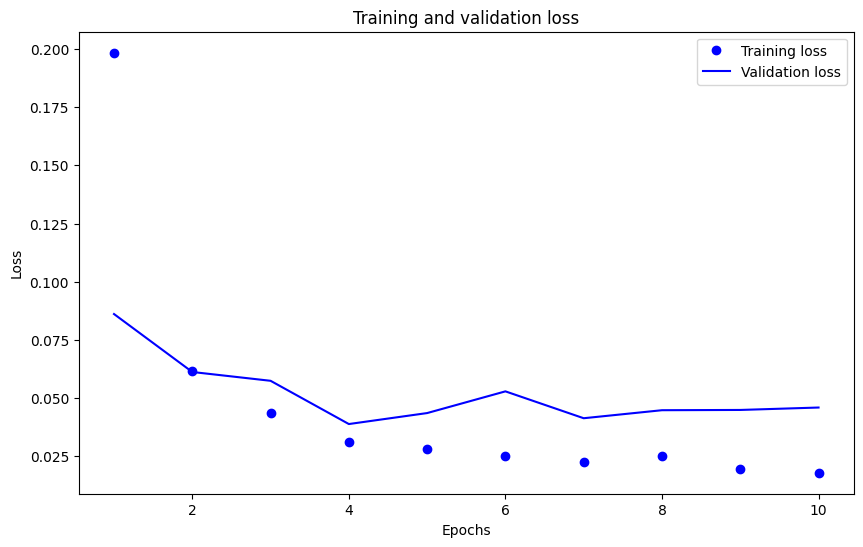

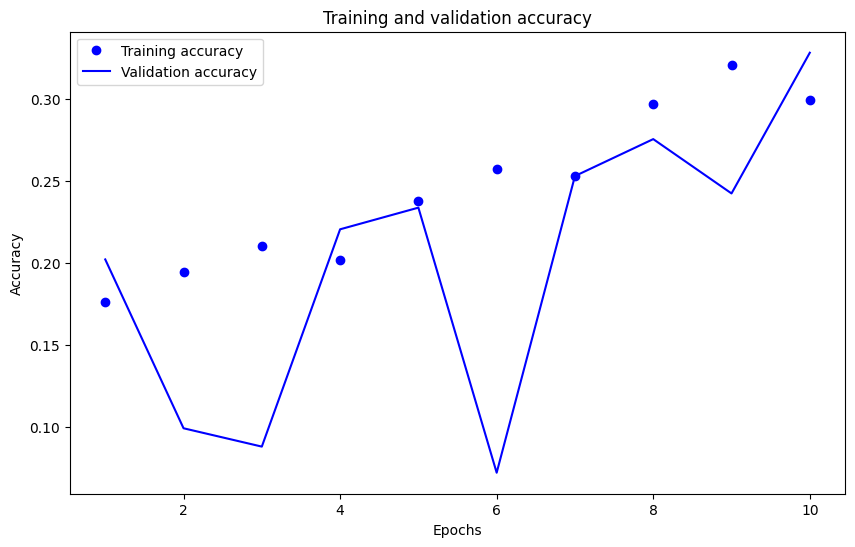

In [ ]:
import matplotlib.pyplot as plt

# Get the training history
history_dict = history.history

# Plot training and validation loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Calculate metrics for each class

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Get predictions for the validation set
# We need to use the validation generator to get the images and then predict using the model.
# Since the generator yields batches, we'll iterate through the validation data using the generator
# to collect all predictions and true labels.

all_val_preds = []
all_val_labels = []

# Reset the validation generator to start from the beginning
val_generator_eval = data_generator(val_paths, val_labels, batch_size)


for i in range(validation_steps):
    images, labels = next(val_generator_eval)
    preds = model.predict(images)
    all_val_preds.append(preds)
    all_val_labels.append(labels)

# Concatenate predictions and labels from all batches
all_val_preds = np.concatenate(all_val_preds)
all_val_labels = np.concatenate(all_val_labels)

# Convert predicted probabilities to binary labels (0 or 1) using a threshold (e.g., 0.5)
predicted_labels = (all_val_preds > 0.5).astype(int)

# Calculate precision, recall, and F1-score for each class
# The 'average=None' argument ensures that metrics are calculated for each class individually
precision, recall, f1_score, _ = precision_recall_fscore_support(
    all_val_labels, predicted_labels, average=None
)

# Get the list of fruit names to associate with the metrics
# Assuming 'fruit_columns' is available from the label analysis step
fruit_names = fruit_columns

# Print the metrics for each class
print("Metrics per class:")
for i, fruit_name in enumerate(fruit_names):
    print(f"  {fruit_name}:")
    print(f"    Precision: {precision[i]:.4f}")
    print(f"    Recall: {recall[i]:.4f}")
    print(f"    F1-score: {f1_score[i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

Try inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


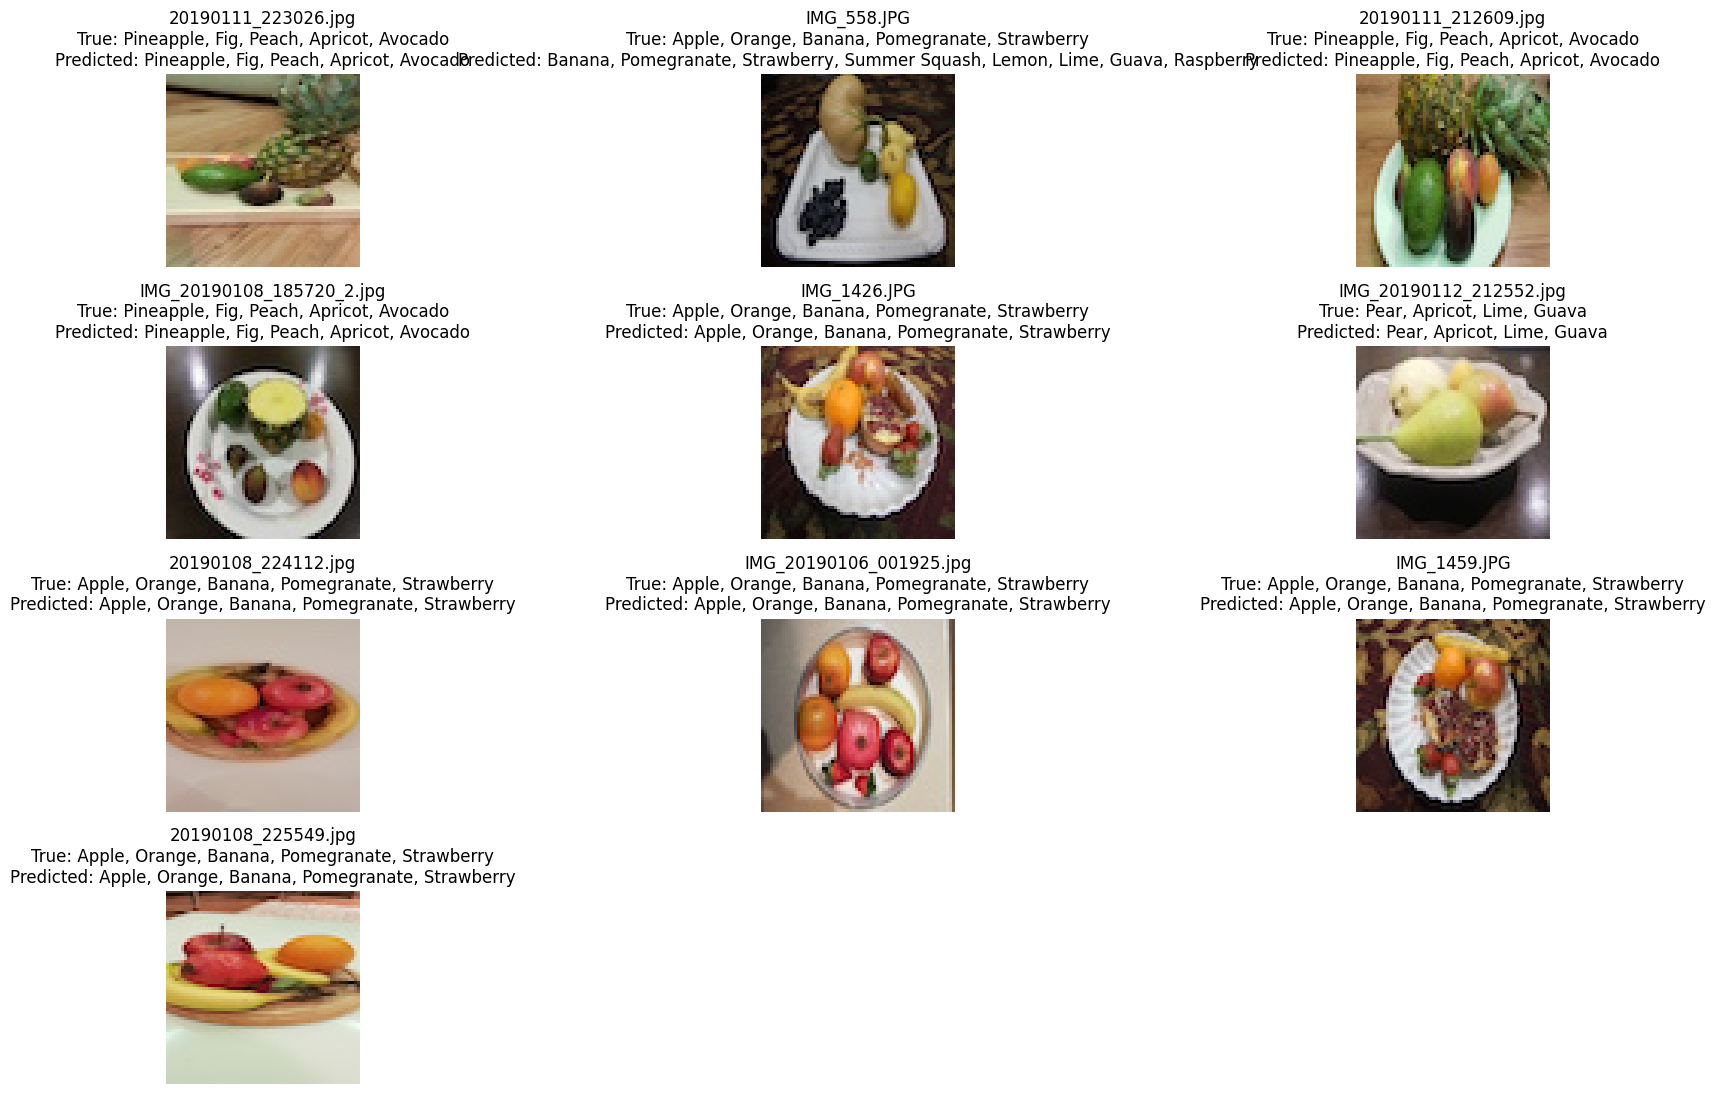

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import os

# Select a few random images from the validation set
num_inference_examples = 10
random_indices = random.sample(range(len(val_paths)), num_inference_examples)

inference_paths = [val_paths[i] for i in random_indices]
inference_true_labels = [val_labels[i] for i in random_indices]

plt.figure(figsize=(18, 12)) # Adjusted figure size

# Arrange images in a 2x3 grid (or similar based on num_inference_examples)
rows = (num_inference_examples + 2) // 3 # Calculate number of rows needed
cols = 3 # Number of columns

# Select the first num_inference_examples from the shuffled list
images_to_display = [all_image_files[i] for i in random_indices] # Use random_indices

for i, image_path in enumerate(images_to_display):
    # Load and preprocess the image
    img = Image.open(image_path)
    ax = plt.subplot(rows, cols, i + 1) # Arrange images in the calculated grid
    ax.imshow(img)
    ax.axis('off')

    # Get the filename from the image path
    file_name = os.path.basename(image_path)

    # Find the row in the labels DataFrame that matches the filename
    label_row = all_labels_df[all_labels_df['FileName'] == file_name]

    # Get the labels for this image
    labels = []
    if not label_row.empty:
        # Get the list of fruit columns (excluding 'FileName')
        fruit_columns = all_labels_df.columns.tolist()
        fruit_columns.remove('FileName')
        for fruit_col in fruit_columns:
            if label_row[fruit_col].iloc[0] == 1:
                labels.append(fruit_col)

    # Get the model's prediction
    # Need to load and preprocess the image again for prediction as it's a separate loop
    img_pred = load_img(image_path, target_size=(img_height, img_width))
    img_array_pred = img_to_array(img_pred)
    img_array_pred = img_array_pred / 255.0  # Normalize pixel values
    img_array_pred = np.expand_dims(img_array_pred, axis=0) # Add batch dimension
    predictions = model.predict(img_array_pred)
    predicted_labels = (predictions > 0.5).astype(int)[0]
    predicted_fruit_names = [fruit_names[j] for j, label in enumerate(predicted_labels) if label == 1]


    # Create the title with true and predicted labels, and filename
    title = f"{file_name}\nTrue: {', '.join(labels) if labels else 'None'}\nPredicted: {', '.join(predicted_fruit_names) if predicted_fruit_names else 'None'}"

    ax.set_title(title)


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent titles overlapping figure title
plt.show()

Save model

In [ ]:
# Save the model
model_save_path = "fruit_recognition_model.keras"
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: fruit_recognition_model.h5


New dataset for fine-tuning

In [28]:
import dask.dataframe as dd

splits = {'train': 'data/train-*.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = dd.read_parquet("hf://datasets/ethanjxu/fruit_images/" + splits["train"])

In [29]:
# Display the first few rows of the Dask DataFrame
display(df.head())

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,89
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,154
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,9
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,148
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,145


Could not display image 10: num must be an integer with 1 <= num <= 10, not 11
Could not display image 11: num must be an integer with 1 <= num <= 10, not 12
Could not display image 12: num must be an integer with 1 <= num <= 10, not 13
Could not display image 13: num must be an integer with 1 <= num <= 10, not 14
Could not display image 14: num must be an integer with 1 <= num <= 10, not 15
Could not display image 15: num must be an integer with 1 <= num <= 10, not 16
Could not display image 16: num must be an integer with 1 <= num <= 10, not 17
Could not display image 17: num must be an integer with 1 <= num <= 10, not 18
Could not display image 18: num must be an integer with 1 <= num <= 10, not 19
Could not display image 19: num must be an integer with 1 <= num <= 10, not 20


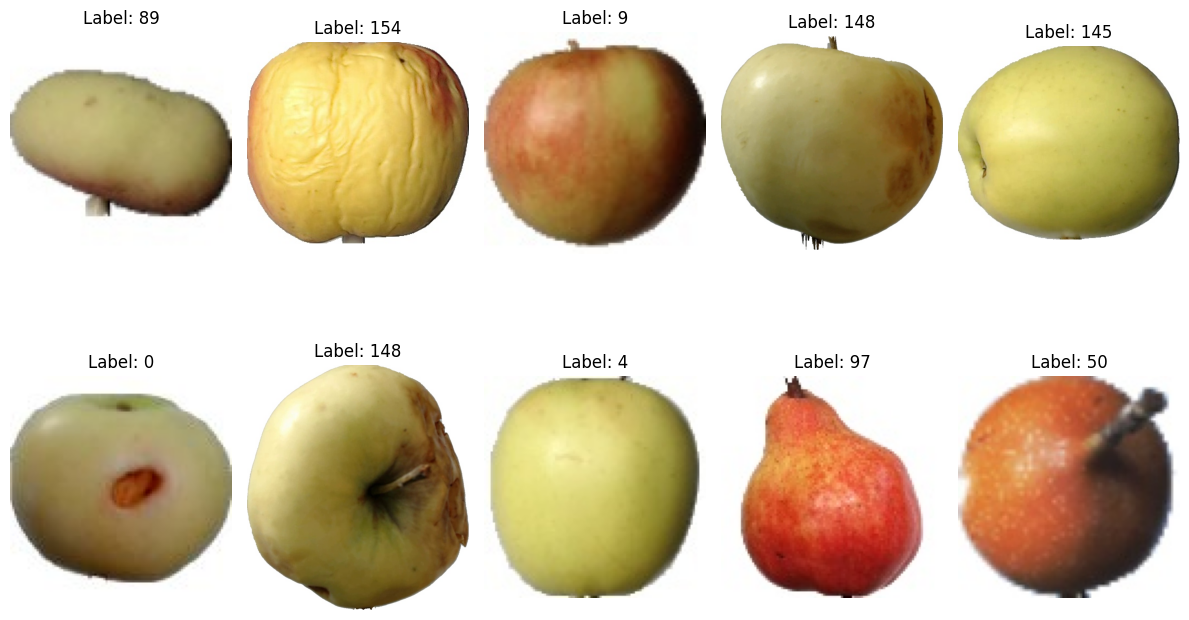

In [32]:
import matplotlib.pyplot as plt
from PIL import Image
import io

# Take a small sample of the Dask DataFrame and convert it to a pandas DataFrame
# This is necessary to work with the image data directly
sample_df = df.head(20) # You can adjust the number of samples

plt.figure(figsize=(12, 8))

for i, row in sample_df.iterrows():
    image_bytes = row['image']['bytes']
    label = row['label']

    try:
        # Open the image from bytes
        img = Image.open(io.BytesIO(image_bytes))

        ax = plt.subplot(2, 5, i + 1) # Arrange images in a 2x5 grid
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    except Exception as e:
        print(f"Could not display image {i}: {e}")


plt.tight_layout()
plt.show()